### 1 : Importing Libraries

In [12]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [13]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *

 ### 2 Reading Data

In [14]:
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
%time
dataset = pd.read_csv('Data/cleaned_data.csv')

CPU times: user 29 µs, sys: 3 µs, total: 32 µs
Wall time: 63.2 µs


In [15]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [16]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [17]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebooks/' location
import sqlite3
from sqlite3 import Error

def create_connection(file):
    #create a database connection to a SQLite database
    connection = None
    try:
        connection = sqlite3.connect(file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if connection:
            connection.close()

if __name__ == '__main__':
    create_connection("lead_scoring_model_experimentation.db")

2.6.0


In [18]:
'''
Now you need to start the MLflow server in a new terminal. 
Note: Before you start the MLflow server, create a folder named mlruns in the assignment directory.
Now you need to run the command to start MLflow server such that:
1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.
2. mlruns folder is used as an artifact directory. 
3. The server runs on the port 6006.

The steps to do so are as follows:
Open a new terminal.
Then go to the Assignment directory using the cd command. Type the command: cd Assignment/
Create a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns
Then, type the following command to start the MLflow server: 
c
'''

'\nNow you need to start the MLflow server in a new terminal. \nNote: Before you start the MLflow server, create a folder named mlruns in the assignment directory.\nNow you need to run the command to start MLflow server such that:\n1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.\n2. mlruns folder is used as an artifact directory. \n3. The server runs on the port 6006.\n\nThe steps to do so are as follows:\nOpen a new terminal.\nThen go to the Assignment directory using the cd command. Type the command: cd Assignment/\nCreate a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns\nThen, type the following command to start the MLflow server: \nc\n'

In [19]:
# Once, your server is successfully running, create a mlflow tracking uri at "http://0.0.0.0:6006"
mlflow.set_tracking_uri("http://0.0.0.0:6006")

In [20]:
# setup pycaret 
exp_lead_scoring = setup(data=dataset,
                   target = 'app_complete_flag',  
                   fold_shuffle=True, 
                   session_id = 42,
                   normalize = True, 
                   transformation = True, 
                   remove_multicollinearity = True, 
                   multicollinearity_threshold = 0.95,
                   n_jobs=-1,
                   use_gpu=True,
                   log_experiment=True,
                   experiment_name='Lead_Scoring_Model_Experimentation',
                   log_plots=True, 
                   log_data=True, 
                   verbose=True,
                   log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 12)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


2024/10/29 21:34:24 INFO mlflow.tracking.fluent: Experiment with name 'Lead_Scoring_Model_Experimentation' does not exist. Creating a new experiment.


### 4 : Model Experimentation with pycaret

In [21]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
exp_model = compare_models(fold = 5,exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7382,0.8211,0.8325,0.7022,0.7618,0.4759,0.4845,6.2220
xgboost,Extreme Gradient Boosting,0.7381,0.8209,0.8286,0.7033,0.7608,0.4756,0.4835,1.0640
et,Extra Trees Classifier,0.7366,0.8178,0.8203,0.7044,0.7579,0.4726,0.4793,5.6620
dt,Decision Tree Classifier,0.7363,0.8169,0.8199,0.7043,0.7577,0.4721,0.4787,0.6400
rf,Random Forest Classifier,0.7346,0.8168,0.8393,0.6957,0.7607,0.4685,0.4790,2.1180
lr,Logistic Regression,0.7170,0.7917,0.8014,0.6875,0.7401,0.4334,0.4396,1.5440
ridge,Ridge Classifier,0.7151,0.0000,0.8141,0.6814,0.7418,0.4296,0.4381,0.4080
lda,Linear Discriminant Analysis,0.7151,0.7904,0.8138,0.6814,0.7417,0.4295,0.4380,1.4520
nb,Naive Bayes,0.6789,0.7383,0.8537,0.6343,0.7278,0.3565,0.3804,0.2620


In [22]:
# create a model which gives the highest accuracy
lightgbm = create_model('lightgbm')

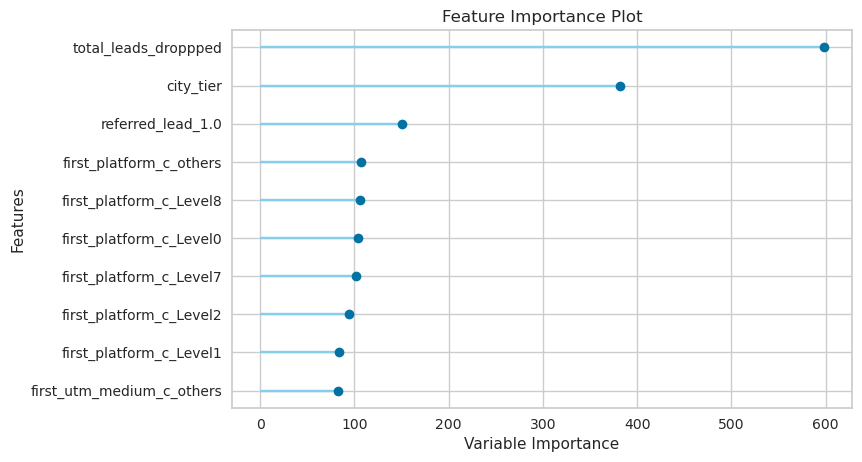

In [23]:
# create feature importance plot
plot_model(lightgbm, plot='feature')

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [24]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.
cols = ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
dataset_new = dataset[cols]

In [25]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
exp_lead_scoring = setup(data=dataset_new,
                   target = 'app_complete_flag',  
                   fold_shuffle=True, 
                   session_id = 42,
                   categorical_features = ['city_tier', 'first_platform_c','first_utm_medium_c', 'first_utm_source_c'],
                   remove_multicollinearity = True, 
                   multicollinearity_threshold = 0.95,
                   n_jobs=-1,
                   use_gpu=False,
                   log_experiment=True,
                   experiment_name='Lead_Scoring_Model_Experimentation_After_Dropping_Features',
                   log_plots=True, 
                   log_data=True,
                   silent=True, 
                   verbose=True,
                   log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 7)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


2024/10/29 21:39:40 INFO mlflow.tracking.fluent: Experiment with name 'Lead_Scoring_Model_Experimentation_After_Dropping_Features' does not exist. Creating a new experiment.


In [26]:
best_model = compare_models(fold = 10,exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7385,0.8211,0.8325,0.7025,0.7620,0.4764,0.4849,1.8770
xgboost,Extreme Gradient Boosting,0.7382,0.8211,0.8306,0.7027,0.7613,0.4758,0.4840,10.1370
rf,Random Forest Classifier,0.7368,0.8186,0.8232,0.7037,0.7588,0.4731,0.4802,2.9380
et,Extra Trees Classifier,0.7364,0.8178,0.8204,0.7042,0.7579,0.4723,0.4790,3.4250
dt,Decision Tree Classifier,0.7363,0.8172,0.8202,0.7041,0.7577,0.4720,0.4787,0.1640
lr,Logistic Regression,0.7097,0.7841,0.8219,0.6731,0.7401,0.4187,0.4294,0.9260
ridge,Ridge Classifier,0.6998,0.0000,0.7960,0.6695,0.7272,0.3989,0.4064,0.0730
lda,Linear Discriminant Analysis,0.6998,0.7733,0.7959,0.6695,0.7272,0.3989,0.4063,0.8020
nb,Naive Bayes,0.6732,0.7337,0.8569,0.6284,0.7250,0.3451,0.3709,0.0660


In [27]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret
lightgbm_2 = create_model('lightgbm')

In [28]:
!pip install scikit-optimize

In [29]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC
import skopt
lgbmTunes, tuner = tune_model(lightgbm, 
                                   search_library = 'scikit-optimize',
                                   fold = 10,
                                   optimize = 'auc',
                                   choose_better = True, 
                                   return_tuner=True)

In [30]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
print(lgbmTunes)

LGBMClassifier(bagging_fraction=0.887437593014418, bagging_freq=1,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', feature_fraction=0.7588282465072769,
               importance_type='split', learning_rate=0.037577891518562063,
               max_depth=-1, min_child_samples=53, min_child_weight=0.001,
               min_split_gain=0.09545503921499346, n_estimators=229, n_jobs=-1,
               num_leaves=224, objective=None, random_state=42,
               reg_alpha=1.074527356155175, reg_lambda=1.7978270329637185e-06,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
